Import libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.decomposition import PCA
from scipy.stats import zscore
%matplotlib inline

# In this problem set, we are often iterating with small Lambda values that cause many warnings to appear. 
# So, we'll turn off warnings for this set:
import warnings
warnings.filterwarnings('ignore')

/Users/filipmichalsky/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Face Recognition

** In this example, we will look at how to use projections and linear regression to classify a test face into one from a series of train faces.**

Read sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, the model leverages the concept that "patterns from a single-object class lie on a linear subspace."   It also makes use of the idea of linear regression as a problem about projections.  In this case, given a vector $y$, the goal is to find the subspace induced by $\mathrm{Col} \, \mathbf X$ that produced the 'closest' projection vector $\widehat y$ to the original $y$.  

### Question 2a

As discussed in the paper, our face dataset contains cleaned images of faces belonging to different people. Assuming that patterns (faces) from one class (person) are elements of the same subspace, let's try to classify an unknown face using the method presented in the paper.  For each class $i$, we need to:

1. construct the $\mathbf H_i$ hat matrix from known faces, being careful to follow the column concatenation step described in the paper to convert an image into its vector representation;
2. calculate the predicted $\widehat y_i$, the closest vector in $\mathrm{Col} \, \mathbf X_i$ to $y$; and
3. calculate the magnitude of the difference vector between $y$ and $\widehat y_i$.

You should then be able to make a classification decision.

**Notes:**
- Use the provided code to download and re-sample the dataset.
- Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
- Your classifier should have approximately an 80% accuracy.
- Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
- Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.
    
### Question 2b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

In [16]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [17]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels,random_state=10)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

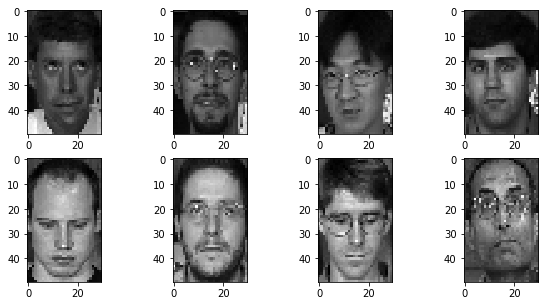

In [18]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()

In [19]:
train_dataset.shape

(600, 50, 30)

In [20]:
train_dataset[0,:,:] #printing the first face

array([[  54.077,   46.718,   56.995, ...,   49.152,   57.006,   52.778],
       [  52.006,   46.875,   53.152, ...,   50.885,   55.212,   54.995],
       [  52.316,   44.006,   52.152, ...,   38.96 ,   51.244,   57.778],
       ..., 
       [ 180.058,  170.927,  177.89 , ...,  118.894,  130.905,  131.118],
       [ 170.976,  175.329,  177.041, ...,  120.894,  131.905,  136.976],
       [ 172.204,  174.204,  180.215, ...,  124.905,  142.905,  143.019]])

In [21]:
#reshape faces classes so that each face is represented by a 1D array
X = train_dataset.reshape(600, train_dataset.shape[1] * train_dataset.shape[2])/255 #reshaping our classes of faces
Y = test_dataset.reshape(150, test_dataset.shape[1] * test_dataset.shape[2])/255

In [22]:
#create a dictionary of train faces
train_face_dict ={}
test_face_dict = {}

for label in train_labels:
    train_face_dict[label] = train_dataset[train_labels == label].reshape(12, train_dataset.shape[1] *train_dataset.shape[2]).T
    
#now get the labels for 
#for label in test_labels:
#    test_face_dict[label] = test_dataset[test_labels == label].reshape(3, train_dataset.shape[1] *train_dataset.shape[2])

In [23]:
def find_min_val_dict(my_dict):
    min_val=1000000000
    key_name = 'nothing'
    for key in my_dict:
        if my_dict[key] < min_val:
            min_val = my_dict[key]
            key_name = key
    return key_name

In [24]:
#initialize L2 norm distance to project

# classifying ALL faces - iterate through the test set and for each face, 
# choose the minimum error in projecting onto the subspace of training faces.
# Each training "face" contains several images, each for a slightly different angle of the face.
# The projection with the minimal error will be our "classification".

d_i={}
answers = []
correct = 0
mismatch =0

#iterate trhough the test faces
for i in range(len(Y)):
    y_0=Y[i]
    current_test_label=test_labels[i] #the position of the label matches the order of test faces
    #projection on a subspace of 12 variations of the same face in below for loop
    for key in train_face_dict:
        XTXinvXT = np.dot( np.linalg.inv(np.dot(train_face_dict[key].T, train_face_dict[key])) , train_face_dict[key].T)

        hat = np.dot(train_face_dict[key], XTXinvXT)
        y_hat = np.dot(hat, y_0)
        #L2 Norm
        l2_norm=np.linalg.norm(y_0-y_hat)
        d_i[key] = l2_norm
    answers.append(find_min_val_dict(d_i))
    if current_test_label == find_min_val_dict(d_i):
        correct = correct + 1
        print("The test face {} is mostly similar to train face {}".format(i,find_min_val_dict(d_i)))
    else:
        mismatch = mismatch + 1
        print("Mismatch : The test face {} is incorrectly categorized as train face {}".format(i,find_min_val_dict(d_i)))

    
print(correct)
print(mismatch)

The test face 0 is mostly similar to train face 2
The test face 1 is mostly similar to train face 36
The test face 2 is mostly similar to train face 30
The test face 3 is mostly similar to train face 3
Mismatch : The test face 4 is incorrectly categorized as train face 30
The test face 5 is mostly similar to train face 5
The test face 6 is mostly similar to train face 10
The test face 7 is mostly similar to train face 4
The test face 8 is mostly similar to train face 49
Mismatch : The test face 9 is incorrectly categorized as train face 22
The test face 10 is mostly similar to train face 42
The test face 11 is mostly similar to train face 41
The test face 12 is mostly similar to train face 48
The test face 13 is mostly similar to train face 42
The test face 14 is mostly similar to train face 44
The test face 15 is mostly similar to train face 27
The test face 16 is mostly similar to train face 5
The test face 17 is mostly similar to train face 12
Mismatch : The test face 18 is incorrec

The test face 147 is mostly similar to train face 11
Mismatch : The test face 148 is incorrectly categorized as train face 22
The test face 149 is mostly similar to train face 44
120
30


In [25]:
print("The algorithm accuracy is",correct/(correct+mismatch))

The algorithm accuracy is 0.8


The classifition based on projections might be incorrect in case of "alignment" of the general face structure (See an example below).

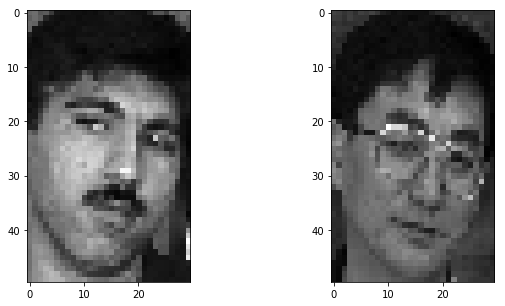

In [26]:
##Incorrectly classified face
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
#[axes[i].imshow(train_dataset[train_labels==46], cmap='gray')]
axes[0].imshow(train_dataset[train_labels==30][0], cmap='gray')
axes[1].imshow(test_dataset[4], cmap='gray')
plt.show()




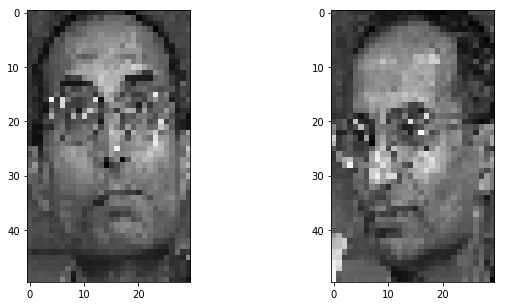

In [27]:
#correctly classified face
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
#[axes[i].imshow(train_dataset[train_labels==46], cmap='gray')]
axes[0].imshow(train_dataset[train_labels==36][0], cmap='gray')
axes[1].imshow(test_dataset[1], cmap='gray')
plt.show()

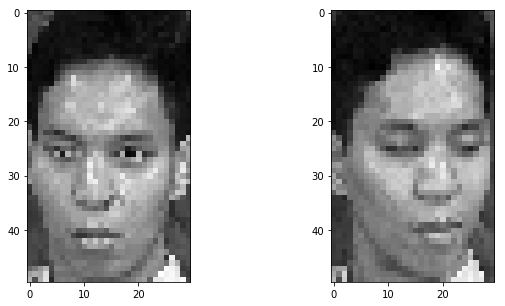

In [28]:
#correctly classified face
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes = axes.flatten()
#[axes[i].imshow(train_dataset[train_labels==46], cmap='gray')]
axes[0].imshow(train_dataset[train_labels==3][0], cmap='gray')
axes[1].imshow(test_dataset[3], cmap='gray')
plt.show()

Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

(1500, 12) (1500,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     449.4
Date:                Thu, 12 Oct 2017   Prob (F-statistic):               0.00
Time:                        19:38:31   Log-Likelihood:                -6873.6
No. Observations:                1500   AIC:                         1.377e+04
Df Residuals:                    1487   BIC:                         1.384e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7611      1.453 

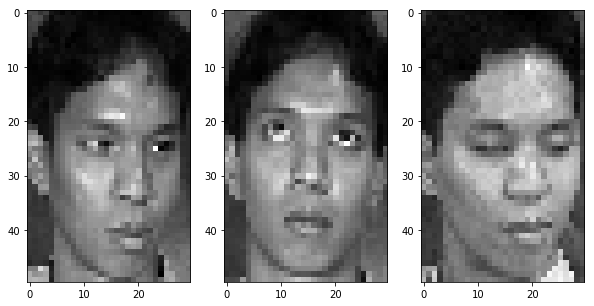

In [29]:
#x_train will be the predictive known faces
x_train = train_dataset[train_labels==3]

x_train = x_train.reshape(12,x_train.shape[1]*x_train.shape[2]).T

#y_train will be our unknown faces
y_train = test_dataset[3]

y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1])
#train_dataset.shape[1] * train_dataset.shape[2])/255
print(x_train.shape,y_train.shape)

train_ols=sm.OLS(y_train,sm.add_constant(x_train))

fitted_model =train_ols.fit()
print(fitted_model.summary())
#getting the betas for each face
model_params = fitted_model.params


fig, axes = plt.subplots(1,3,figsize=(10,5))
axes = axes.flatten()

pvalues=fitted_model.pvalues

print("Most Contributing/ Least Contributing / True Image")
axes[0].imshow(train_dataset[train_labels==3][model_params[1:].argmax(axis=0)], cmap='gray')

axes[1].imshow(train_dataset[train_labels==3][pvalues.argmax(axis=0)], cmap='gray')

axes[2].imshow(test_dataset[3], cmap='gray')
plt.show()

It is clear that the most contributing face from our training set is always the one with the closest projection of the true face while the least contributing training "face" will the be one really differing from the test face.



